In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution
import pyfits
from astropy.modeling.models import Voigt1D
import warnings
from __future__ import print_function
from pylab import *
import math

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

%matplotlib inline

In [198]:
hdu = pyfits.open("hlsp_muscles_multi_multi_gj176_broadband_v21_adapt-var-res-sed.fits")
wave = hdu[1].data["WAVELENGTH"]
flux = hdu[1].data["FLUX"]
err = hdu[1].data["ERROR"]

print(len(wave))
print(len(flux))

c = 299792458e10
RV = 26 * (10 ** 13)#short_stars_rv[j] * (10 ** 13)
wave = wave / (1 + RV / c)

1164177
1164177


In [199]:
def ready_lsf(orig_lsf_wave, orig_lsf , grating_disp, data_wave):
    data_wave_spacing = data_wave[1]-data_wave[0]
    data_wave_length = len(data_wave)
    lsf_lam_min = np.round(np.min(orig_lsf_wave*grating_disp)/data_wave_spacing) * data_wave_spacing
    lsf_lam_onesided = np.arange(lsf_lam_min,0,data_wave_spacing)  ### Make sure it's even and doesn't include zero
    if len(lsf_lam_onesided) % 2 != 0:
        lsf_lam_onesided = lsf_lam_onesided[1::] # get rid of the first element of the array

    lsf_lam_flipped = lsf_lam_onesided[::-1]
    lsf_lam_pluszero=np.append(lsf_lam_onesided,np.array([0]))
    lsf_lam=np.append(lsf_lam_pluszero,lsf_lam_flipped) # should be odd

    lsf_interp = np.interp(lsf_lam,orig_lsf_wave*grating_disp,orig_lsf/np.sum(orig_lsf))
    lsf_interp_norm = lsf_interp/np.sum(lsf_interp) # I don't know why I do np.sum() for normalization...

    if data_wave_length < len(lsf_interp_norm):
        lsf_interp_norm = np.delete(lsf_interp_norm,np.where(lsf_interp_norm == 0))
        lsf_interp_norm = np.insert(lsf_interp_norm,0,0)
        lsf_interp_norm = np.append(lsf_interp_norm,0)

    return lsf_interp_norm

##################################################################

lsf = np.loadtxt("cos_g130m.txt", skiprows=1)
dispersion = wave[1]-wave[0] # number of Å per pixel
lsf_kernel = ready_lsf(lsf[:,0], lsf[:,1], dispersion, wave)

#Defining a functions
def gaussian(x, amp, cen, wid):
    model =  amp*np.exp(-(x-cen)**2/(2*wid**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

def double_gauss(x, amp1, cen1, wid1, amp2, cen2, wid2):
    model = amp1*np.exp(-(x-cen1)**2/(2*wid1**2)) + amp2*np.exp(-(x-cen2)**2/(2*wid2**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

##################################################################

#https://stackoverflow.com/questions/44652776/python-curve-fit-choice-of-bounds-and-initial-condition-affect-the-result

# bounds on parameters are set in generate_Initial_Parameters() below

# function for genetic algorithm to minimize (sum of squared error)
# bounds on parameters are set in generate_Initial_Parameters() below

def sse_g(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    g_fit = gaussian(wave, *parameterTuple)
    return np.sum((flux - g_fit)**2) #/ g_fit)

def generate_p0_g(peak_flux, line, window):
    parameterBounds = []
    parameterBounds.append([(peak_flux)*0.9, (peak_flux)*1.1]) # parameter bounds for amp  
    parameterBounds.append([line, line]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_g, parameterBounds)#, seed=2019)
    return result.x

def sse_dg(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    dg_fit = double_gauss(wave, *parameterTuple)
    return np.sum((flux - dg_fit)**2) #/ dg_fit)

def generate_p0_dg(amp1, amp2, cen1, cen2, window):
    parameterBounds = []
    parameterBounds.append([(amp1)*0.5, (amp1)*1.5]) # parameter bounds for amp  
    parameterBounds.append([cen1, cen1]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    parameterBounds.append([(amp2)*0.5, (amp2)*1.5]) # parameter bounds for amp  
    parameterBounds.append([cen2, cen2]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_dg, parameterBounds)#, seed=2019)
    return result.x

In [200]:
print(np.max(line_window[0]))
print(wave)

mask = np.logical_and(wave<(line_waves[0][-1]+np.max(line_window[0])), wave>(line_waves[0][0]-np.max(line_window[0])))
print(mask)
print(len(mask))
print(len(flux))
#print(wave[mask])
#print(flux[mask])

1
[  5.00000792e+00   5.00200521e+00   5.00400394e+00 ...,   5.49944805e+04
   5.49947305e+04   5.49949805e+04]
[False False False ..., False False False]
1164177
1164177


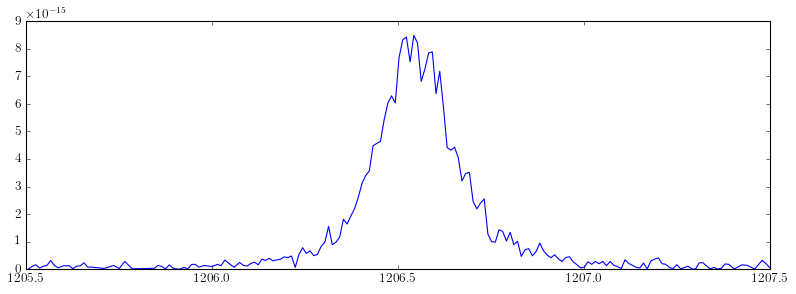

In [206]:
line_names = ["CII", "CIV", "HeII", "NV", "SiII", "SiIII", "SiIV"] #"MgII",
line_waves = [[1335.71], [1548.19,1550.78], [1640.4], [1238.82,1242.8060],
              [1260.42,1265.00], [1206.50], [1393.76,1402.77]] #[2796.35,2803.53],
line_window = [[0.7], [1,1], [1], [2,2], [0.7,1], [1], [1,1]] #"X",
#note: 1265.00 represents both 1264.74 and 1265.00

line_names = ["SiIII"]
line_waves = [[1206.50]]
line_window = [[1]]

#plot the raw data to see whats around it
plt.figure(figsize=(12,4))
plt.plot(wave[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))], 
         flux[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))])
plt.xlim(line_waves[0][0]-np.max(line_window),line_waves[0][-1]+np.max(line_window))
#plt.ylim(0,1.1*9.640308440905302e-16)
plt.ticklabel_format(useOffset=False)
#plt.xlim(1264, 1266)
plt.show()

## Plotting one line at a time with Kevin's fits

SiIII
1206.5
Peak Spectral Flux 8.48375789473e-15
Gaussian
Kevin Flux:  2.15e-15
Chi2:  4.53271473296e+105
GAUSSIAN FLUX TOTAL:  2.13021659913e-15


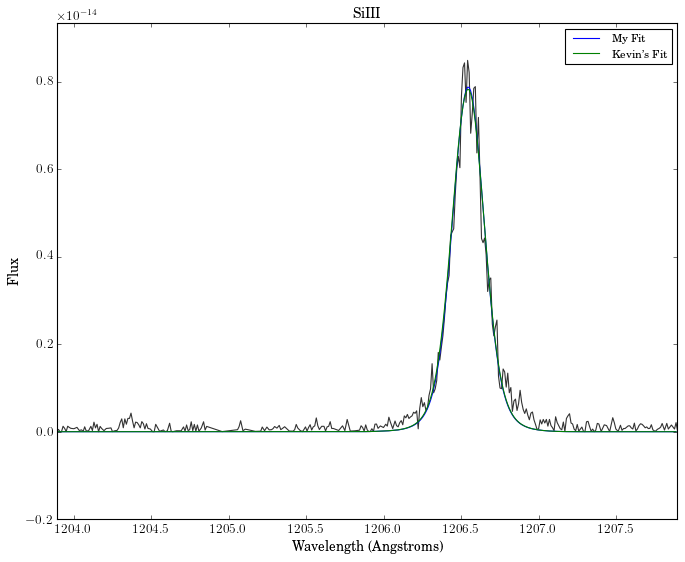

In [208]:
#Kevin's fits:
kevin_lamba = 1206.65 / (1 + RV / c) #[1393.89,1401.28,1402.90], 
kevin_width = ((52.7*10**13)/c*kevin_lamba)/2.35482 #[40.4,21.9,43.4],
kevin_amp = 2.15E-015/(np.sqrt(2*pi)*kevin_width) #[1.47E-015,1.11E-016,7.21E-016],
kevin_lobound = 1204.00 / (1 + RV / c)
kevin_hibound = 1208.00 / (1 + RV / c)

kevin_g = gaussian(wave[(wave<kevin_hibound) & (wave>kevin_lobound)], kevin_amp, kevin_lamba, kevin_width) 

## ONE GRAPH AT A TIME ##

g_fluxes = []
g_amps = []
g_sigmas = []

colors=["mediumslateblue", "firebrick", "peachpuff"]

for i in range(len(line_names)):
    ##########################
    plt.figure(figsize=(10,8))
    plt.xlim(kevin_lobound,kevin_hibound)
    plt.ylim(-2*10**(-15),1.1*np.max(flux[(wave<(line_waves[i][-1]+np.max(line_window[i]))) & (wave>(line_waves[i][0]-np.max(line_window[i])))]))
    plt.plot(wave, flux, alpha = 0.8, color="black") #label="Spectra"
    plt.xlabel("Wavelength (Angstroms)")
    plt.ylabel("Flux")
    plt.title(r"%s" % line_names[i])
    plt.ticklabel_format(useOffset=False)
    ##########################
    
    print(line_names[i])
    
    line_total_int_g = []
    all_orders_of_mag = []
    
    for j in range(len(line_waves[i])):
        
        line=line_waves[i][j]
        print(line)

        max_window = float(line_window[i][j])
        min_window = float(line_window[i][j])
        #print("Window: ", window)

        peak_flux = np.max(flux[(wave<(line+0.2)) & (wave>(line-0.2))])
        #avg_line_flux = np.mean(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))])
        #amp_guess = line_amps[i]

        print("Peak Spectral Flux", peak_flux)
        #print("Avg Spectral Line Flux", avg_line_flux)

        ##########################
        
        window = max_window

        print("Gaussian")
        if line == 1265:
            print("Fitting a double gaussian")
            amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
            amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])

            p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)

            print(amp1, amp2)
            #param_bounds=([-np.inf,1264.5,-np.inf,-np.inf,1264.8,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf,1265.2,np.inf,np.inf])
            popt_g, pcov_g = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                       np.array(flux[(wave<1265.5) & (wave>1264)]), 
                                       p0 = p0_dg, 
                                       maxfev=2500) #[amp1,1264.74,0.06,amp2,1265.00,0.04,1e-16] #bounds = param_bounds,
            g = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                         popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3], popt_g[4], abs(popt_g[5]))

            residuals_g = (flux[(wave<1265.5) & (wave>1264)] - g) #/ np.sum(dg_std)
            chi2_g = np.sum(residuals_g**2 / g)
            dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
            # len(result[‘x’]) gives the number of fitted parameters

            print("Chi2: ", chi2_g)

            int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
            #np.trapz(g - popt_g[6], wave[(wave<1265.5) & (wave>1264)], 0.002) #np.sum(g - popt_g[3])
            #print("GAUSSIAN FLUX: ", int_g)

            plt.plot(wave[(wave<1265.5) & (wave>1264)], g, alpha=1)
            #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
            #plt.fill_between(wave[(wave<1265.5) & (wave>1264)], g, alpha=0.5, label=line, color=colors[j])

        else:
            p0_g = generate_p0_g(peak_flux, line, window)
            #print("Initial Gaussian Params: ", p0_g)

            #param_bounds=([peak_flux*.8,line-0.1,0,0],[peak_flux*1.2,line+0.1,0.8,0])
            popt_g, pcov_g = curve_fit(gaussian, wave[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                                       flux[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                                       #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                       p0 = p0_g, maxfev=2500)

            #print("Gaussian Parameters \n")
            #print("Amp: ", popt_g[0], "Center: ", popt_g[1], "Width: ", popt_g[2], "Offset: ", popt_g[3])

            g = gaussian(wave[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                         popt_g[0], popt_g[1], abs(popt_g[2]))
            
            int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
            int_g_kevin = kevin_amp * kevin_width * np.sqrt(2*pi)
            print("Kevin Flux: ", int_g_kevin)
            #np.trapz(g - popt_g[3], wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #np.sum(g - popt_g[3])
            #print("GAUSSIAN FLUX: ", int_g)
            
            """###################################
            p0_g = generate_p0_v(peak_flux, line, window)
            p0_g[4] = 0
            
            popt_g, pcov_g = curve_fit(voigt, wave[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                           flux[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                           #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                           p0 = p0_g, maxfev=2500)

            #print("Gaussian Parameters \n")
            #print("Amp: ", popt_g[0], "Center: ", popt_g[1], "Width: ", popt_g[2], "Offset: ", popt_g[3])

            g = voigt(wave[(wave<kevin_hibound) & (wave>kevin_lobound)], 
                         popt_g[0], popt_g[1], abs(popt_g[2]), abs(popt_g[3]), 0)
                                 
            int_g = np.trapz(g, wave[(wave<kevin_hibound) & (wave>kevin_lobound)], 0.002) 
            #popt_g[0] * popt_g[2] * np.sqrt(2*pi)
            int_g_kevin = kevin_amp * kevin_width * np.sqrt(2*pi)
            print("Kevin Flux: ", int_g_kevin)
            #np.trapz(g - popt_g[3], wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #np.sum(g - popt_g[3])
            #print("GAUSSIAN FLUX: ", int_g)
            ###################################################"""

            residuals_g = (flux[(wave<kevin_hibound) & (wave>kevin_lobound)] - g) #/ np.sum(dg_std)
            chi2_g = np.sum(residuals_g**2 / g)
            dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
            # len(result[‘x’]) gives the number of fitted parameters

            print("Chi2: ", chi2_g)
            
            order_of_mag = np.floor(np.log10(popt_g[0]))
            all_orders_of_mag.append(order_of_mag)

            max_mag = np.max(order_of_mag)

            int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
            #np.trapz(g - popt_g[3], wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #np.sum(g - popt_g[3])
            #print("GAUSSIAN FLUX: ", int_g)

            plt.plot(wave[(wave<kevin_hibound) & (wave>kevin_lobound)],  g, alpha=1, label="My Fit")
            #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
            #plt.fill_between(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=0.5, label="%s \AA" % line, color=colors[j])


            #plt.plot(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=1, label="My Fit")#, color=colors[j])
            #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
            plt.plot(wave[(wave<kevin_hibound) & (wave>kevin_lobound)], kevin_g, alpha=1, label="Kevin's Fit")
            #plt.fill_between(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=0.5, label=line, color=colors[j])

        line_total_int_g.append(int_g)

        ###############################

        g_fluxes.append(line_total_int_g)
        g_amps.append(popt_g[0])
        g_sigmas.append(abs(popt_g[2]))

    print("GAUSSIAN FLUX TOTAL: ", np.sum(line_total_int_g))
    plt.legend(loc="best", fontsize=10) #title='TOTAL FLUX: %s' % np.sum(g_fluxes))
    #plt.savefig("Graphs/%s_fits.png" % line_names[i])
    #plt.xlim(1206,1206.5)
    plt.show()

In [202]:
print(popt_g)
perr = np.sqrt(np.diag(pcov_g))
#print(perr)
#print(kevin_g)
print(kevin_lamba)
print(kevin_width)
print(kevin_amp)

[  9.63313835e-15   1.20654653e+03   8.82198309e-02]
1206.54536035
0.0900691056762
9.52297567988e-15


## Plotting each line for a target individually and getting fluxes

CII
1335.71
Peak Spectral Flux 2.45452246329e-14
Gaussian
Window:  0.7
Chi2:  9.40768054368e-14
Max_mag -14.0
GAUSSIAN FLUX TOTAL:  5.29392895082e-15


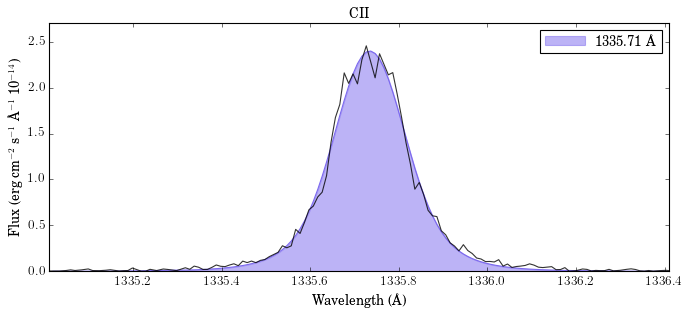

CIV
1548.19
Peak Spectral Flux 3.26984375287e-14
Gaussian
Window:  1.0
Chi2:  9.85231082351e-11
Max_mag -14.0
1550.78
Peak Spectral Flux 1.68819853035e-14
Gaussian
Window:  1.0
Chi2:  2.91805845099e-13
Max_mag -14.0
GAUSSIAN FLUX TOTAL:  1.1946898772e-14


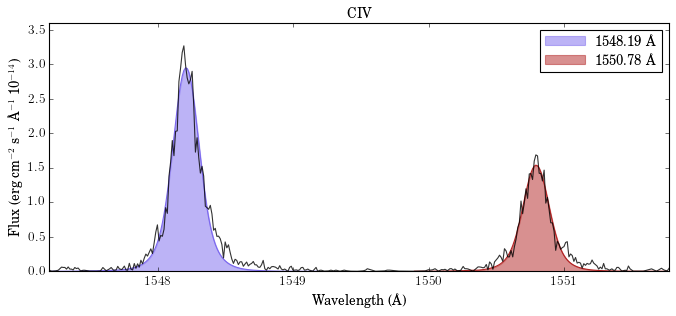

HeII
1640.4
Peak Spectral Flux 2.66441605032e-14
Gaussian
Window:  1.0
Chi2:  4.27834687252e-13
Max_mag -14.0
GAUSSIAN FLUX TOTAL:  6.65061462438e-15


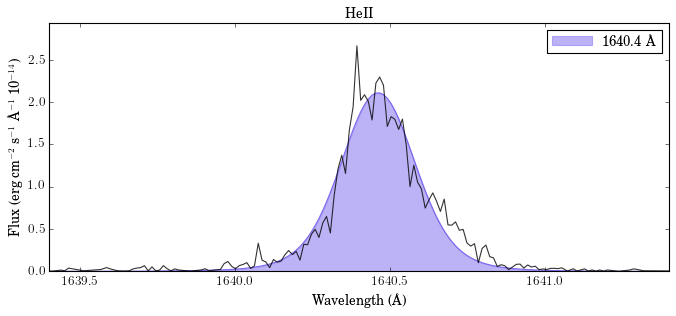

NV
1238.82
Peak Spectral Flux 1.04900869655e-14
Gaussian
Window:  2.0
Chi2:  2.32805165747e+59
Max_mag -14.0
1242.806
Peak Spectral Flux 5.15029255949e-15
Gaussian
Window:  2.0
Chi2:  3.85556690741e+64
Max_mag -14.0
GAUSSIAN FLUX TOTAL:  2.97924458101e-15


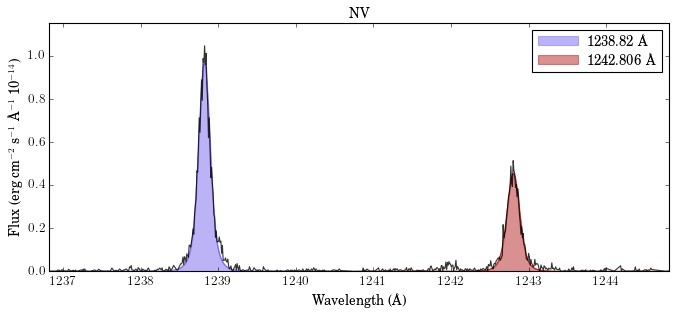

SiII
1260.42
Peak Spectral Flux 9.64030844091e-16
Gaussian
Window:  0.7
Chi2:  3.82031475557e-13
Max_mag -16.0
1265.0
Peak Spectral Flux 1.52667984396e-15
Gaussian
Window:  1.0
Fitting a double gaussian
2.55660470191e-15 1.1834325951e-15
Chi2:  1.80925643702e-14
GAUSSIAN FLUX TOTAL:  7.2176435172e-16


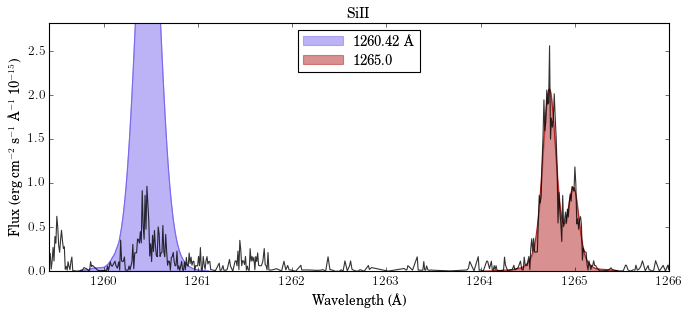

SiIII
1206.5
Peak Spectral Flux 8.48375789473e-15
Gaussian
Window:  1.0
Chi2:  2.60020227306e-09
Max_mag -15.0
GAUSSIAN FLUX TOTAL:  2.13021680863e-15


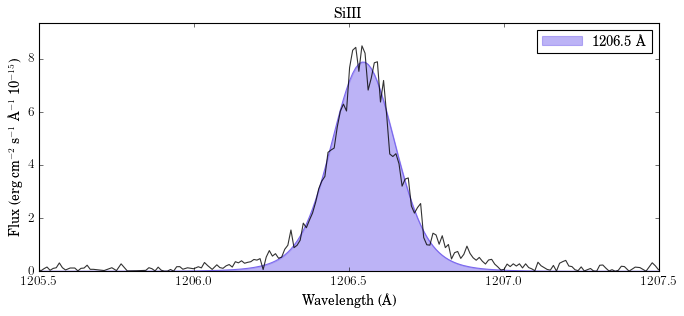

SiIV
1393.76
Peak Spectral Flux 6.95550570829e-15
Gaussian
Window:  1.0
Chi2:  4.85655309466e-11
Max_mag -15.0
1402.77
Peak Spectral Flux 3.46793747755e-15
Gaussian
Window:  1.0
Chi2:  1.27556145693e-12
Max_mag -15.0
GAUSSIAN FLUX TOTAL:  2.13887533103e-15


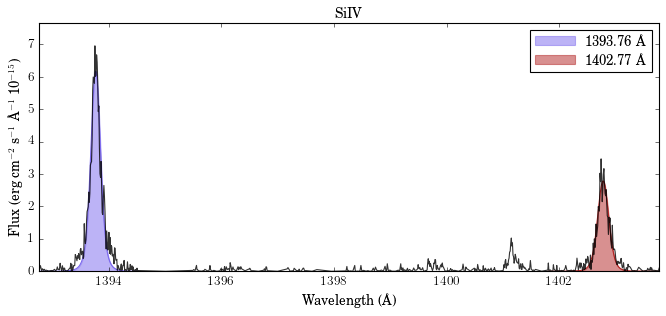

In [204]:
## ONE GRAPH AT A TIME ##

g_fluxes = []
g_amps = []
g_sigmas = []

colors=["mediumslateblue", "firebrick", "peachpuff"]

for i in range(len(line_names)):
    ##########################
    plt.figure(figsize=(10,4))
    plt.xlabel("Wavelength (\AA)")
    plt.xlim(line_waves[i][0]-np.max(np.array(line_window[i])),line_waves[i][-1]+np.max(np.array(line_window[i])))
    plt.title(r"%s" % line_names[i])
    plt.ticklabel_format(useOffset=False)
    ##########################
    
    print(line_names[i])
    
    line_total_int_g = []
    all_orders_of_mag = []
    
    for j in range(len(line_waves[i])):
        
        line=line_waves[i][j]
        print(line)

        max_window = float(line_window[i][j])
        min_window = float(line_window[i][j])
        #print("Window: ", window)

        peak_flux = np.max(flux[(wave<(line+0.2)) & (wave>(line-0.2))])
        #avg_line_flux = np.mean(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))])
        #amp_guess = line_amps[i]

        print("Peak Spectral Flux", peak_flux)
        #print("Avg Spectral Line Flux", avg_line_flux)

        ##########################

        ## GAUSSIAN FIT ##
        #############################
        window = max_window

        print("Gaussian")
        while window >= min_window:
            print("Window: ", window)
            try:
                if line == 1265:
                    print("Fitting a double gaussian")
                    amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                    amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])
                    
                    p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)
                    
                    print(amp1, amp2)
                    #param_bounds=([-np.inf,1264.5,-np.inf,-np.inf,1264.8,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf,1265.2,np.inf,np.inf])
                    popt_g, pcov_g = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                               np.array(flux[(wave<1265.5) & (wave>1264)]), 
                                               p0 = p0_dg, 
                                               maxfev=2500) #[amp1,1264.74,0.06,amp2,1265.00,0.04,1e-16] #bounds = param_bounds,
                    g = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                                 popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3], popt_g[4], abs(popt_g[5])) #, popt_g[6])
                    
                    residuals_g = (flux[(wave<1265.5) & (wave>1264)] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)

                    int_g = np.trapz(g, wave[(wave<1265.5) & (wave>1264)], 0.002) #np.sum(g - popt_g[3])
                    #popt_g[0] * popt_g[2] * np.sqrt(2*pi) #
                    #print("GAUSSIAN FLUX: ", int_g)
                    
                    max_mag = -15

                    plt.plot(wave[(wave<1265.5) & (wave>1264)], g/(10**(-15)), alpha=1, color=colors[j])
                    #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
                    plt.fill_between(wave[(wave<1265.5) & (wave>1264)], g/(10**(-15)), alpha=0.5, label=line, color=colors[j])
                
                else:
                    p0_g = generate_p0_g(peak_flux, line, window)
                    #print("Initial Gaussian Params: ", p0_g)
                    
                    #param_bounds=([peak_flux*.8,line-0.1,0,-np.inf],[amp*1.2,line+0.1,0.8,np.inf])
                    popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(line+window)) & (wave>(line-window))], 
                                               flux[(wave<(line+window)) & (wave>(line-window))], 
                                               #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                               p0 = p0_g, maxfev=2500)

                #print("Gaussian Parameters \n")
                #print("Amp: ", popt_g[0], "Center: ", popt_g[1], "Width: ", popt_g[2], "Offset: ", popt_g[3])

                    g = gaussian(wave[(wave<(line+window)) & (wave>(line-window))], 
                                 popt_g[0], popt_g[1], abs(popt_g[2])) #, popt_g[3])

                    residuals_g = (flux[(wave<(line+window)) & (wave>(line-window))] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)
                    
                    order_of_mag = np.floor(np.log10(popt_g[0]))
                    all_orders_of_mag.append(order_of_mag)
                    
                    max_mag = np.max(all_orders_of_mag)
                    print("Max_mag", max_mag)

                    int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
                    #np.trapz(g - popt_g[3], wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #np.sum(g - popt_g[3])
                    #print("GAUSSIAN FLUX: ", int_g)

                    plt.plot(wave[(wave<(line+window)) & (wave>(line-window))],  g/(10**max_mag), alpha=1, color=colors[j])
                    #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
                    plt.fill_between(wave[(wave<(line+window)) & (wave>(line-window))],  g/(10**max_mag),
                                     alpha=0.5, label="%s \AA" % line, color=colors[j])
                
                line_total_int_g.append(int_g)

                window = window - 0.5

            except RuntimeError:
                print("No Gaussian fit found")
                window = window - 0.5

        ###############################

        g_fluxes.append(line_total_int_g)
        g_amps.append(popt_g[0])
        g_sigmas.append(abs(popt_g[2])) 

    print("GAUSSIAN FLUX TOTAL: ", np.sum(line_total_int_g))
    
    plt.ylim(0,1.1*np.max(flux[(wave<(line_waves[i][-1]+np.max(line_window[i]))) 
                               & (wave>(line_waves[i][0]-np.max(line_window[i])))])/(10**max_mag))
    plt.plot(wave, flux/(10**max_mag), alpha = 0.8, color="black") #label="Spectra"
    plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$ 10$^{%s}$)" % int(max_mag))
    legend = plt.legend(loc="best", fontsize=12) #title='TOTAL FLUX: %s' % np.sum(g_fluxes))
    legend.get_title().set_fontsize('14')
    #plt.savefig("Graphs/%s_fits.png" % line_names[i])
    plt.show()

## Plotting all lines for one target at once (for display/example purposes)

CII
Peak Spectral Flux 2.45452246329e-14
Gaussian
Window:  0.7
Chi2:  9.32369402633e-15
GAUSSIAN FLUX TOTAL:  5.20300524863e-15
CIV
Peak Spectral Flux 3.26984375287e-14
Gaussian
Window:  1
Chi2:  4.61165969145e-14
Peak Spectral Flux 1.68819853035e-14
Gaussian
Window:  1
Chi2:  2.8047929496e-14
GAUSSIAN FLUX TOTAL:  1.11424319166e-14
HeII
Peak Spectral Flux 2.66441605032e-14
Gaussian
Window:  1
Chi2:  5.51599087972e-14
GAUSSIAN FLUX TOTAL:  6.28882689294e-15
NV
Peak Spectral Flux 1.04900869655e-14
Gaussian
Window:  2
Chi2:  1.62838988793e-14
Peak Spectral Flux 5.15029255949e-15
Gaussian
Window:  2
Chi2:  2.47519693946e-14
GAUSSIAN FLUX TOTAL:  2.88139325783e-15
SiII
Peak Spectral Flux 9.64030844091e-16
Gaussian
Window:  0.7
Chi2:  9.54697322916e-15
Peak Spectral Flux 2.55660470191e-15
Gaussian
Window:  1
Fitting a double gaussian
2.55660470191e-15 1.1834325951e-15
Chi2:  6.0447197732e-15
GAUSSIAN FLUX TOTAL:  1.08107320191e-15
SiIII
Peak Spectral Flux 8.48375789473e-15
Gaussian
Window: 

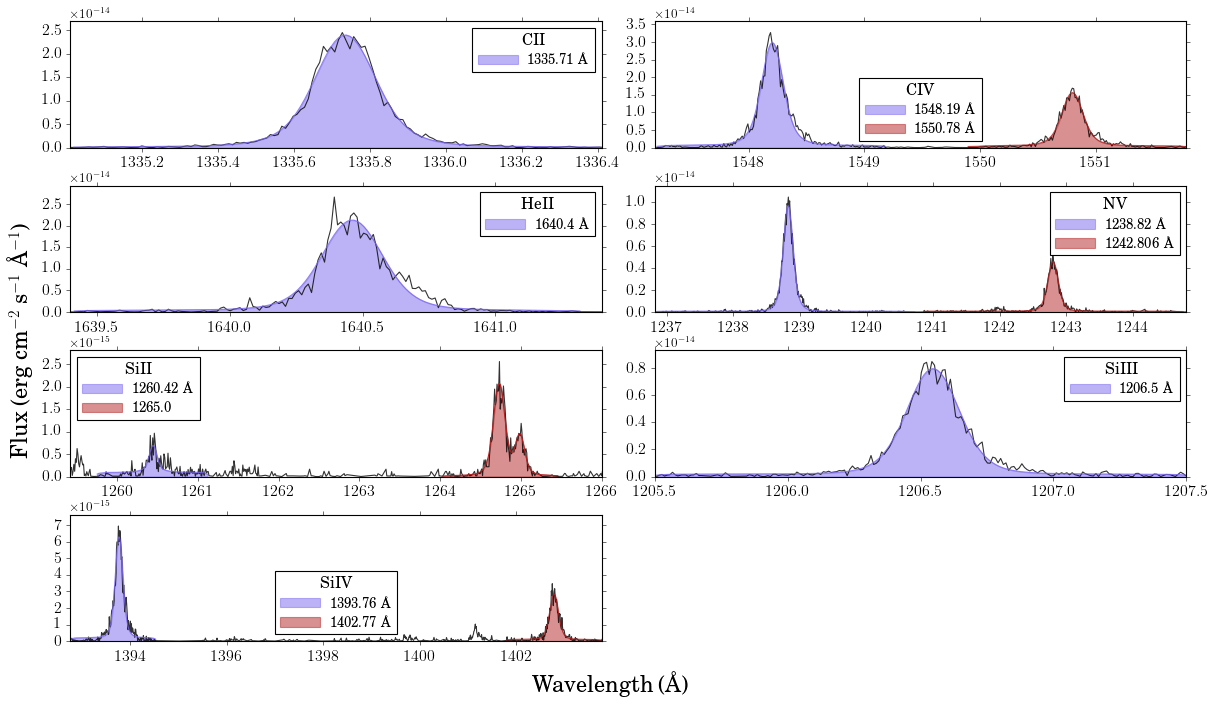

In [86]:
## ALL THE GRAPHS AT ONCE ##

fig = figure(figsize=(18,10))
subplots_adjust(wspace=0.1,hspace=0.3)
fig.text(0.5, 0.07, 'Wavelength (\AA)', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize=20)
colors=["mediumslateblue", "firebrick", "peachpuff"]

g_fluxes = []
g_amps = []
g_sigmas = []
g_offsets = []

for i in range(len(line_names)):
    print(line_names[i])
    ##########################
    #plt.figure(figsize=(10,4))
    iplot = 420 + i + 1
    axs = fig.add_subplot(iplot)
    axs.set_xlim(line_waves[i][0]-np.max(np.array(line_window[i])),line_waves[i][-1]+np.max(np.array(line_window[i])))
    axs.set_ylim(0,1.1*np.max(flux[(wave<(line_waves[i][-1]+np.max(line_window[i]))) 
                                   & (wave>(line_waves[i][0]-np.max(line_window[i])))]))
    axs.plot(wave, flux, alpha = 0.8, color="black") #label="Spectra"
    axs.tick_params(direction='out', labelsize="x-large")
    axs.get_xaxis().get_major_formatter().set_useOffset(False)
    #if iplot >= 425:
        #axs.set_xlabel("Wavelength (Angstroms)", fontsize=10)
    #if (iplot==421 or iplot==425):
        #axs.set_ylabel("Flux", fontsize=10)
    #axs.set_title(r"%s (%s Angstroms)" % (line_names[i], line_waves[i]), fontsize=10)
    #axs[i].set_ticklabel_format(useOffset=False)
    ##########################
    
    line_total_int_g = []
    
    for j in range(len(line_waves[i])):
        
        line=line_waves[i][j]
        #print(line_names[i])
        #print(line_waves[i])

        max_window = line_window[i][j]
        min_window = line_window[i][j]
        #print("Window: ", window)

        peak_flux = np.max(flux[(wave<(line+max_window)) & (wave>(line-max_window))])
        #avg_line_flux = np.mean(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))])
        #amp_guess = line_amps[i]

        print("Peak Spectral Flux", peak_flux)
        #print("Avg Spectral Line Flux", avg_line_flux)

        ##########################

        ## GAUSSIAN FIT ##
        #############################
        window = max_window

        print("Gaussian")
        while window >= min_window:
            print("Window: ", window)
            try:
                if line == 1265:
                    print("Fitting a double gaussian")
                    amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                    amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])
                    
                    p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)
                    
                    print(amp1, amp2)
                    #param_bounds=([-np.inf,1264.5,-np.inf,-np.inf,1264.8,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf,1265.2,np.inf,np.inf])
                    popt_g, pcov_g = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                               np.array(flux[(wave<1265.5) & (wave>1264)]), 
                                               p0 = p0_dg, 
                                               maxfev=2500) #[amp1,1264.74,0.06,amp2,1265.00,0.04,1e-16] #bounds = param_bounds,
                    g = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                                 popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3], popt_g[4], abs(popt_g[5]), popt_g[6])
                    
                    residuals_g = (flux[(wave<1265.5) & (wave>1264)] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)

                    int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
                    #np.trapz(g - popt_g[6], wave[(wave<1265.5) & (wave>1264)], 0.002) #np.sum(g - popt_g[3])
                    #print("GAUSSIAN FLUX: ", int_g)

                    axs.plot(wave[(wave<1265.5) & (wave>1264)], g, alpha=1, color=colors[j])
                    #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
                    axs.fill_between(wave[(wave<1265.5) & (wave>1264)], g, alpha=0.5, label=line, color=colors[j])
                    
                else:
                    p0_g = generate_p0_g(peak_flux, line, window)
                    #print("Initial Gaussian Params: ", p0_g)
                    
                    popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(line+window)) & (wave>(line-window))], 
                                               flux[(wave<(line+window)) & (wave>(line-window))], 
                                               #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                               p0 = p0_g, maxfev=2500)

                    #print("Gaussian Parameters \n")
                    #print("Amp: ", popt_g[0], "Center: ", popt_g[1], "Width: ", popt_g[2], "Offset: ", popt_g[3])

                    g = gaussian(wave[(wave<(line+window)) & (wave>(line-window))], popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3])

                    residuals_g = (flux[(wave<(line+window)) & (wave>(line-window))] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)
                    
                    order_of_mag = np.floor(np.log10(popt_g[0]))

                    int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)
                    #np.trapz(g - popt_g[3], wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #np.sum(g - popt_g[3])
                    #print("GAUSSIAN FLUX: ", int_g)

                    axs.plot(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=0.8, color=colors[j]) 
                             #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g), alpha=1)
                    axs.fill_between(wave[(wave<(line+window)) & (wave>(line-window))], g, 
                                     alpha=0.5, label="%s \AA" % line, color=colors[j])
                    
                line_total_int_g.append(int_g)

                window = window - 0.5

            except RuntimeError:
                print("No Gaussian fit found")
                window = window - 0.5

        ###############################

        g_fluxes.append(line_total_int_g)
        g_amps.append(popt_g[0])
        g_sigmas.append(abs(popt_g[2]))
        g_offsets.append(popt_g[3])

    print("GAUSSIAN FLUX TOTAL: ", np.sum(line_total_int_g))
    legend = axs.legend(loc="best", title='%s' % line_names[i], fontsize=12)
    legend.get_title().set_fontsize('14')

savefig("Graphs/all_uv_fits.png")
plt.show()

In [ ]:
print(popt_g)
print(p0_dg)
#print(line)
print(g_fluxes)
#print(p0_g)

#print(float(max_window)/2)
#print(len(wave[(wave<(line+window)) & (wave>(line-window)) & (wave>1264.74)]))
#print(len(flux[(wave<(line+window)) & (wave>(line-window)) & (wave>1264.74)]))
#print(p0_g)
#print(len(g))
#print(len(np.array(flux[(wave<(line+window/2)) & (wave>line-window/2)])))
#print(line-window/2)

"""amp = np.max(flux[(wave<1265.3) & (wave>1264.9)])
print(amp)
param_bounds=([amp*.9,1264.8,0,-np.inf],[amp*1.1,1265.2,0.5,np.inf])
popt_g, pcov_g = curve_fit(gaussian, np.array(wave[(wave<(line+window)) & (wave>line-window)]), 
       np.array(flux[(wave<(line+window)) & (wave>line-window)]), 
       p0 = [amp,1265.00,0.05,1.00000000e-16], 
       bounds = param_bounds, maxfev=2500)

print(popt_g)

g = gaussian(wave[(wave<(line+window)) & (wave>(line-window))], popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3])
plt.plot(wave, flux, alpha = 0.8, color="black") #label="Spectra"
plt.plot(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=1)
plt.ylim(0,0.3e-14)
plt.xlim(1260,1270)
plt.show()"""

In [ ]:
fig = figure(figsize=(16,8))
subplots_adjust(wspace=0.1,hspace=0.3)
fig.text(0.5, 0.07, 'Wavelength (Angstroms)', ha='center', va='center', fontsize=16)
fig.text(0.09, 0.5, 'Flux', ha='center', va='center', rotation='vertical', fontsize=16)
x = np.random.rand(20)
y = np.random.rand(20)
iplot = 420
for i in range(7):
    iplot += 1
    ax = fig.add_subplot(iplot)
    ax.plot(x,y,'ko')
    ax.text(np.min(x)+0.03, np.max(y)-.1, "CI")
    #ax.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax.set_xlabel("x")
    #ax.set_ylabel("y")

In [ ]:
print(g_amps)
print(g_sigmas)
print(g_offsets)
print(g_fluxes)
print(axs)

                if line == 1264.74:
                    amp = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                    param_bounds=([-np.inf,1264.5,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf])
                    popt_g, pcov_g = curve_fit(gaussian, np.array(wave[(wave<(line+window)) & (wave>line-window)]), 
                                               np.array(flux[(wave<(line+window)) & (wave>line-window)]), 
                                               p0 = [amp,1264.74,0.5,1e-16], 
                                               bounds = param_bounds, maxfev=2500)
                if line == 1265:
                    amp = np.max(flux[(wave<1265.3) & (wave>1264.9)])
                    param_bounds=([amp*.9,1264.8,0,-np.inf],[amp*1.1,1265.2,0.5,np.inf])
                    popt_g, pcov_g = curve_fit(gaussian, np.array(wave[(wave<(line+window)) & (wave>line-window)]), 
                           np.array(flux[(wave<(line+window)) & (wave>line-window)]), 
                           p0 = [amp,1265.00,0.05,1e-16], 
                           bounds = param_bounds, maxfev=2500)
                else:

# ALL THREE MODELS:

In [184]:
def voigt(x, amp, cen, wid_L, wid_G, c):
    v_func = Voigt1D(x_0=cen, amplitude_L=amp, fwhm_L=wid_L, fwhm_G=wid_G)
    model = v_func(x) #+ c
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

def double_gauss(x, amp1, cen1, wid1, amp2, cen2, wid2, c):
    model = amp1*np.exp(-(x-cen1)**2/(2*wid1**2)) + amp2*np.exp(-(x-cen2)**2/(2*wid2**2)) + c
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

def sse_v(parameterTuple):#sum of squared error minimization
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    v_fit = voigt(wave, *parameterTuple)
    return np.sum((flux - v_fit)**2) #/ v_fit)

def sse_dg(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    dg_fit = double_gauss(wave, *parameterTuple)
    return np.sum((flux - dg_fit)**2) #/ dg_fit)

def generate_p0_dg(peak_flux, line, window):
    parameterBounds = []
    parameterBounds.append([(peak_flux)*0.5, (peak_flux)*1.5]) # parameter bounds for amp  
    parameterBounds.append([line, line]) # parameter bounds for cen
    parameterBounds.append([1, 1]) # parameter bounds for wid
    parameterBounds.append([(peak_flux)*0.5, (peak_flux)*1.5]) # parameter bounds for amp  
    parameterBounds.append([line-window, line+window]) # parameter bounds for cen
    parameterBounds.append([1, 1]) # parameter bounds for wid
    parameterBounds.append([1e-16, 1e-16]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_dg, parameterBounds)#, seed=2019)
    return result.x

def generate_p0_v(peak_flux, line, window):
    parameterBounds = []
    parameterBounds.append([(peak_flux)*0.9, (peak_flux)*1.1]) # parameter bounds for amp 
    parameterBounds.append([line, line]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_v, parameterBounds)#, seed=2019)
    return result.x

In [ ]:
v_fluxes = []
g_fluxes = []
dg_fluxes = []

for i in range(len(line_names)):
    print(line_names[i])
    print(line_waves[i])
    
    max_window = line_window[i]
    min_window = 2
    #print("Window: ", window)
    
    peak_flux = np.max(flux[(wave<(line_waves[i]+max_window)) & (wave>(line_waves[i]-max_window))])
    #avg_line_flux = np.mean(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))])
    #amp_guess = line_amps[i]
    
    print("Peak Spectral Flux", peak_flux)
    #print("Avg Spectral Line Flux", avg_line_flux)
    
    ##########################
    plt.figure(figsize=(10,4))
    plt.xlim(line_waves[i]-window,line_waves[i]+window)
    plt.ylim(0,1.1*np.max(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))]))
    plt.plot(wave, flux, label="Spectra", alpha = 0.8, color="black")
    plt.xlabel("Wavelength (Angstroms)")
    plt.ylabel("Flux")
    plt.title(r"%s (%s Angstroms)" % (line_names[i], line_waves[i]))
    plt.ticklabel_format(useOffset=False)
    ##########################
    
    
    ## VOIGHT FIT ##
    #############################
    window = max_window
    
    all_v = []
    all_chi2 = []
    all_int_v = []
    
    print("Voight")
    while window >= min_window:
        print("Window: ", window)
        try:
            p0_v = generate_p0_v(peak_flux, line_waves[i], window)
            #print("Initial Voight Params: ", p0_v)

            popt, pcov = curve_fit(voigt, wave[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], 
                               flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], p0 = p0_v, maxfev=2500)
                               #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),

            #print("Voigt Parameters \n")
            #print("Amp: ", popt[0], "Center: ", popt[1], "L width: ", popt[2], "G Width: ", popt[3], "Offset: ", popt[4])

            v = voigt(wave, popt[0], popt[1], popt[2], popt[3], popt[4])
            #v_std = np.sqrt(np.diag(pcov))

            residuals = (flux - v) #/ np.sum(v_std) #errors for more than one parameter?
            chi2 = np.sum(residuals**2 / v)
            dof = len(popt) - 1 #len(flux) - len(popt) - 1  
            # len(result[‘x’]) gives the number of fitted parameters
            
            print("Chi2: ", chi2)

            int_v = np.trapz(v - popt[4], wave, 0.01)
            #print("VOIGT FLUX: ", int_v)
            
            all_v.append(v)
            all_chi2.append(chi2)
            all_int_v.append(int_v)
            
            window = window - 0.5

        except RuntimeError:
            print("No Voigt fit found")
            window = window - 0.5
        
    #############################
    
    
    ## GAUSSIAN FIT ##
    #############################
    window = max_window
    
    all_g = []
    all_chi2_g = []
    all_int_g = []
    
    print("Gaussian")
    while window >= min_window:
        print("Window: ", window)
        try:
            p0_g = generate_p0_g(peak_flux, line_waves[i], window)
            #print("Initial Gaussian Params: ", p0_g)
            
            popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], 
                                       flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], 
                                       #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                       p0 = p0_g, maxfev=2500)

            #print("Gaussian Parameters \n")
            #print("Amp: ", popt_g[0], "Center: ", popt_g[1], "Width: ", popt_g[2], "Offset: ", popt_g[3])

            g = gaussian(wave, popt_g[0], popt_g[1], popt_g[2], popt_g[3])

            residuals_g = (flux - g) #/ np.sum(dg_std)
            chi2_g = np.sum(residuals_g**2 / g)
            dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
            # len(result[‘x’]) gives the number of fitted parameters
            
            print("Chi2: ", chi2_g)

            int_g = np.trapz(g - popt_g[3], wave, 0.01)
            #print("GAUSSIAN FLUX: ", int_g)
            
            all_g.append(g)
            all_chi2_g.append(chi2_g)
            all_int_g.append(int_g)

            window = window - 0.5

        except RuntimeError:
            print("No Gaussian fit found")
            window = window - 0.5
        
    ###############################
    
    
    ## DOUBLE GAUSSIAN FIT ##
    ###############################
    window = max_window
    
    all_dg = []
    all_chi2_dg = []
    all_int_dg = []
    
    print("Double Gaussian")
    while window >= min_window:
        print("Window: ", window)
        try:
            p0_dg = generate_p0_dg(peak_flux, line_waves[i], window)
            #print("Initial Double Gaussian Params: ", p0_dg)
            
            popt_dg, pcov_dg = curve_fit(double_gauss, wave[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], 
                                         flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))], 
                                         #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                         p0 = p0_dg, maxfev=2500)

            #print("Double Gaussian Parameters \n")
            #print("Amp1: ", popt_dg[0], "Center1: ", popt_dg[1], "Width1: ", popt_dg[2], "Amp2: ", popt_dg[3], 
                  #"Center2: ", popt_dg[4], "Width2: ", popt_dg[5], "Offset: ", popt_dg[6])

            dg = double_gauss(wave, popt_dg[0], popt_dg[1], popt_dg[2], popt_dg[3], 
                          popt_dg[4], popt_dg[5], popt_dg[6])
            #dg_std = np.sqrt(np.diag(pcov_gauss))

            residuals_dg = (flux - dg) #/ np.sum(dg_std)
            chi2_dg = np.sum(residuals_dg**2 / dg)
            dof_dg = len(popt_dg) - 1 #len(flux) - len(popt_gauss) - 1  
            # len(result[‘x’]) gives the number of fitted parameters
            
            print("Chi2: ", chi2_dg)

            int_dg = np.trapz(dg - popt_dg[6], wave, 0.01)
            #print("DOUBLE GAUSSIAN FLUX: ", int_dg)
            
            all_dg.append(dg)
            all_chi2_dg.append(chi2_dg)
            all_int_dg.append(int_dg)

            window = window - 0.5

        except RuntimeError:
            print("No Double Gaussian fit found")
            window = window - 0.5
    ################################
    
    best_idx_v = np.argmin(all_chi2)
    best_chi2_v = all_chi2[best_idx_v]
    best_window_v = max_window - best_idx_v * 0.5
    best_flux_v = all_int_v[best_idx_v]
    best_v = all_v[best_idx_v]
    
    best_idx_g = np.argmin(all_chi2_g)
    best_chi2_g = all_chi2_g[best_idx_g]
    best_window_g = max_window - best_idx_g * 0.5
    best_flux_g = all_int_g[best_idx_g]
    best_g = all_g[best_idx_g]
    
    best_idx_dg = np.argmin(all_chi2_dg)
    best_chi2_dg = all_chi2_dg[best_idx_dg]
    best_window_dg = max_window - best_idx_dg * 0.5
    best_flux_dg = all_int_dg[best_idx_dg]
    best_dg = all_dg[best_idx_dg]
    
    v_fluxes.append(best_flux_v)
    g_fluxes.append(best_flux_g)
    dg_fluxes.append(best_flux_dg)
    
    print("VOIGT FLUX: ", v_fluxes)
    print("GAUSSIAN FLUX: ", g_fluxes)
    print("DOUBLE GAUSSIAN FLUX: ", dg_fluxes)
    
    all_best_chi2 = [best_chi2_v, best_chi2_g, best_chi2_dg]
    best_overall_fit = ["Voight", "Gaussian", "Double Gaussian"][np.argmin(all_best_chi2)]
    
    plt.plot(wave, best_v, label="Voigt Fit ($\chi_{%s}^2$ = %s)" % (dof, best_chi2_v), alpha=1, color="violet")
    plt.plot(wave, best_g, label="Gaussian ($\chi_{%s}^2$ = %s)" % (dof_g, best_chi2_g), alpha=1, color="limegreen")
    plt.plot(wave, best_dg, label="Double Gaussian ($\chi_{%s}^2$ = %s)" % (dof_dg, best_chi2_dg), alpha=1, color="cornflowerblue")
    plt.legend(loc="best", fontsize=10)
    plt.savefig("Graphs/%s_fits.png" % line_names[i])
    plt.show()

In [ ]:
print(best_overall_fit)

In [ ]:
print(all_chi2)
best_idx_v = np.argmin(np.array(all_chi2))
print(best_idx_v)
best_chi2_v = all_chi2[best_idx_v]
best_window_v = max_window - best_idx_v * 0.5
best_flux_v = all_int_v[best_idx_v]
best_v = all_v[best_idx_v]

best_idx_g = np.argmin(all_chi2_g)
best_chi2_g = all_chi2_g[best_idx_g]
best_window_g = max_window - best_idx_g * 0.5
best_flux_g = all_int_g[best_idx_g]
best_g = all_g[best_idx_g]

best_idx_dg = np.argmin(all_chi2_dg)
best_chi2_dg = all_chi2_dg[best_idx_dg]
best_window_dg = max_window - best_idx_dg * 0.5
best_flux_dg = all_int_dg[best_idx_dg]
best_dg = all_dg[best_idx_dg]

v_fluxes.append(best_flux_v)
g_fluxes.append(best_flux_g)
dg_fluxes.append(best_flux_dg)

all_best_chi2 = [best_chi2_v, best_chi2_g, best_chi2_dg]
best_overall_fit = ["Voight", "Gaussian", "Double Gaussian"][np.argmin(all_best_chi2)]

plt.figure(figsize=(10,4))
plt.xlim(line_waves[i]-window,line_waves[i]+window)
plt.ylim(0,1.1*np.max(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))]))
plt.plot(wave, flux, label="Spectra", alpha = 0.8, color="black")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.title(r"%s (%s Angstroms)" % (line_names[i], line_waves[i]))
plt.ticklabel_format(useOffset=False)
plt.plot(wave, best_v, label="Voigt Fit ($\chi_{%s}^2$ = %s)" % (dof, best_chi2_v), alpha=1, color="violet")
plt.plot(wave, best_g, label="Gaussian ($\chi_{%s}^2$ = %s)" % (dof_g, best_chi2_g), alpha=1, color="limegreen")
plt.plot(wave, best_dg, label="Double Gaussian ($\chi_{%s}^2$ = %s)" % (dof_dg, best_chi2_dg), alpha=1, color="cornflowerblue")
plt.legend(loc="best", fontsize=10)
plt.savefig("Graphs/%s_fits.png" % line_names[i])
plt.show()

In [ ]:
print(voigt_flux)
print(gaussian_flux)
print(double_gaussian_flux)

In [ ]:
#DOUBLE CHECK ALL WAVELENGTHS ARE THE RIGHT ONES (alt MgII: 2802.7056)

hdu = pyfits.open("hlsp_muscles_multi_multi_gj176_broadband_v21_adapt-var-res-sed.fits")
wave = hdu[1].data["WAVELENGTH"]
flux = hdu[1].data["FLUX"]
err = hdu[1].data["ERROR"]

line_names = ["SiII"]
line_waves = [1549]
line_window = [5]

In [ ]:
# generate initial parameter values
#p0_v = generate_p0_v(3.6546281109752893e-14, line_waves[0], line_window[0])
#p0_g = generate_p0_g(3.6546281109752893e-14, line_waves[0], line_window[0])
p0_dg = generate_p0_dg(1.08e-15, 1265, 2)
#initialParameters[1] = 1260.42
#initialParameters[2] = 1
#initialParameters[3] = 1e-15
#print(p0_v)
#print(p0_g)
print(p0_dg)

In [ ]:
print(len(flux[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))]))

In [ ]:
# curve fit the test data
fittedParameters, niepewnosci = curve_fit(gaussian, 
                                          wave[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))],
                                          flux[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))], 
                                          p0= p0_g)
print(fittedParameters)

# create values for display of fitted peak function
amp, cen, wid, c = fittedParameters
y_fit = gaussian(wave[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))], amp, cen, wid, c)

#bounds = [(1e-17,1e-13),(1201,1210),(0,3),(0,1e-16)]
#gaus_guesses = differential_evolution(gaussian, bounds)

In [ ]:
plt.plot(wave[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))], 
         flux[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))]) # plot the raw data
#plt.plot(wave[(wave<(line_waves[0]+line_window[0])) & (wave>(line_waves[0]-line_window[0]))], 
         #y_fit, "red") # plot the equation using the fitted parameters
plt.xlim(line_waves[0]-line_window[0],line_waves[0]+line_window[0])
#plt.ylim(0,1.1*9.640308440905302e-16)
plt.show()

In [ ]:
print(p0_v)

# 

In [ ]:
print(np.max(flux[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]))
print(line_waves[i])
print(len(v))
print(len(flux))
print(np.sum(v_std))

In [ ]:
textstr = 'Flux: %s' % popt[0]

plt.figure(figsize=(10,4))
#plt.xlim(1200, 1250)
plt.xlim(line_waves[i]-2,line_waves[i]+2)
plt.ylim(0,1.1*np.max(flux[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]))
plt.plot(wave[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))], flux[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))], label="Spectra")
plt.plot(wave[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))], voigt(wave[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))], popt[0], popt[1], popt[2], popt[3], popt[4]), label="Voigt Fit")
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.title(r"%s (%s Angstroms);   Flux = %s" % (line_names[i], line_waves[i], popt[0]))
plt.legend(loc="best")
plt.show()

In [ ]:
plt.figure()
plt.plot(wave, flux)
#plt.plot(wave, voigt(wave, popt[0], popt[1], popt[2], popt[3], popt[4]))
plt.xlim(1258,1262)
#plt.xlim(1258,1262)
#plt.xlim(1545,1555)
plt.ticklabel_format(useOffset=False)
plt.ylim(0,1e-15)

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(10, 14), facecolor='w', edgecolor='k', sharex=True)

axs = axs.ravel()

In [ ]:
"""def gaussian(x, amp, cen, wid, c):
    model =  amp*np.exp(-(x-cen)**2/(2*wid**2)) + c
    return model

def voigt(x, amp, cen, wid_L, wid_G, c):
    v_func = Voigt1D(x_0=cen, amplitude_L=amp, fwhm_L=wid_L, fwhm_G=wid_G)
    model = v_func(x) + c
    return model

def double_gauss(x, amp1, cen1, wid1, amp2, cen2, wid2, c):
    model = amp1*np.exp(-(x-cen1)**2/(2*wid1**2)) + amp2*np.exp(-(x-cen2)**2/(2*wid2**2)) + c
    return model"""